In [89]:
#Brain tumor classification using DenseNet Transfer Learning 

2024-01-18 17:46:47,386 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:46:51,677 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:47:51,669 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:48:04,373 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:49:04,376 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:50:04,367 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:50:16,258 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:51:16,259 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:51:31,599 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for th

In [2]:

!pip install torch-summary


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
#from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
#import splitfolders
from torchsummary import summary
#import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [2]:
labels_df = pd.read_csv("/user/ebirgy/home/Downloads/Brain_Tumor_IRM/metadata.csv") # paths needs to be completed 
labels_df.drop(columns=['Unnamed: 0'], inplace=True)
print(labels_df.head().to_markdown())

|    | image           | class   | format   | mode   | shape         |
|---:|:----------------|:--------|:---------|:-------|:--------------|
|  0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


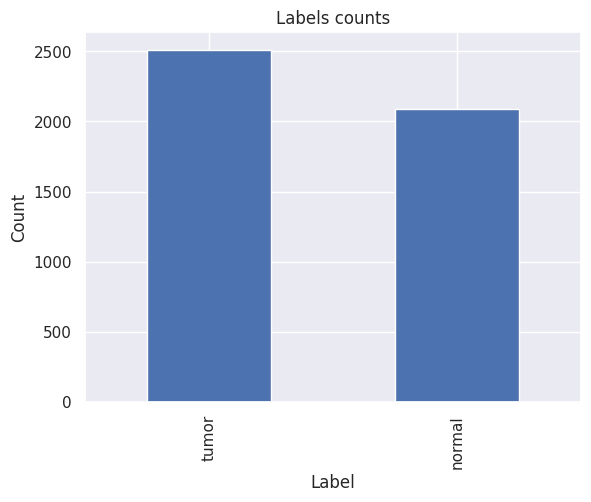

In [3]:
labels_df["class"].value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [4]:
# Encoding des categories : création d'un dictionnaire
label={'tumor': "1", 'normal': "0"}

In [5]:
dict_label=dict(label)
labels_df["label"]=labels_df['class'].map(dict_label)

In [49]:
# Specify the path where the images are located
path = "/user/ebirgy/home/Downloads/Brain_Tumor_IRM/"
# Add a new column 'full_path' to the DataFrame
labels_df['path_images'] = path + labels_df['image']


In [50]:
labels_df.head()

,image,class,format,mode,shape,label,path_images
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...
1,Cancer (1).png,tumor,PNG,L,"(300, 240)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...


In [51]:
dataset=labels_df[['path_images', 'label', 'image']]
dataset['label']=dataset['label'].astype('int')

In [52]:
dataset.head()

,path_images,label,image
0,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (1).jpg
1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (1).png
2,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (1).tif
3,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (10).jpg
4,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (10).tif


In [53]:
dataset.to_csv("../cancer_labels.csv")
df = pd.read_csv("../cancer_labels.csv", index_col=0)

In [54]:
df.iloc[0, 0]

'/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Cancer (1).jpg'

2024-01-18 16:07:44,442 fedbiomed WARNING - Node NODE_7842724a-cafa-49cc-862d-149288bbbb22 is disconnected. Request/task that are created for this node will be flushed
2024-01-18 16:08:32,498 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 16:08:32,498 fedbiomed INFO - Node NODE_7842724a-cafa-49cc-862d-149288bbbb22 is back online!


In [ ]:
# At the end , to evaluate the model 

In [ ]:
# Plot the convergence curve 
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
class_labels = ["Tumor", "No Tumor"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# comments 

In [22]:
from fedbiomed.researcher.requests import Requests
req  = Requests()
req.list()

2024-01-18 15:56:35,458 fedbiomed INFO - Starting researcher service...
2024-01-18 15:56:35,459 fedbiomed INFO - Waiting 3s for nodes to connect...
2024-01-18 15:56:37,492 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 15:56:38,472 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks


{'NODE_7842724a-cafa-49cc-862d-149288bbbb22': [{'name': 'cancel-labels',
   'data_type': 'csv',
   'tags': ['cancer'],
   'description': 'This CSV dataset keeps the information about where brain images are saved',
   'shape': [4600, 4],
   'dataset_id': 'dataset_870df87c-a9ab-44ae-957a-d440bdc1c2f0',
   'dataset_parameters': None}]}

2024-01-18 15:57:38,477 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 15:57:48,181 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks


In [72]:
from fedbiomed.common.training_plans import TorchTrainingPlan 
from fedbiomed.common.data import DataManager
from torch.utils.data import Dataset


class MyTrainingPlan(TorchTrainingPlan):

    def init_model(self, model_args):
        model = models.densenet121(pretrained=True) # # Training of the entire model with your dataset ( a tester !!!)
        return model

    def init_dependencies(self):
        return [
            "import pandas as pd",
            "from PIL import Image",
            "from torchvision import datasets, transforms, models",
            "from torch.utils.data import Dataset",
            "import torch.optim as optim"
        ]


    def init_optimizer(self, optimizer_args):        
        return optim.Adam(self.model().parameters(), lr=optimizer_args["lr"])

    # training data
    class CustomDatasetFedBioMed(Dataset):
        def __init__(self, dataset_path: str, transform=None):
            self.dataframe = pd.read_csv(dataset_path, index_col=0)
            
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
           ])
    
        def __len__(self):
            return len(self.dataframe)
    
        def __getitem__(self, idx):
            
            img_path = self.dataframe.iloc[idx, 0]  # the file path is in the first column
            print(img_path)
            image = Image.open(img_path).convert("RGB")
    
            label = self.dataframe.iloc[idx, 1]  # the class label is in the second column
    
            if self.transform:
                image = self.transform(image)
    
            label = torch.tensor(label, dtype=torch.long)  # if it returns a tuple instead of a tensor
    
            return image, label 

    def training_data(self):
        dataset = self.CustomDatasetFedBioMed(self.dataset_path)
        return DataManager(dataset)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss_func = nn.CrossEntropyLoss()
        loss   = loss_func(output, target)
        return loss




In [73]:
training_args = {
    'loader_args': { 'batch_size': 32, }, 
    'optimizer_args': {'lr': 1e-4}, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}


In [74]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['cancer']
rounds = 1

exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan,
                 #model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage())

2024-01-18 16:49:20,108 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 16:49:20,110 fedbiomed INFO - Node selected for training -> NODE_7842724a-cafa-49cc-862d-149288bbbb22
2024-01-18 16:49:20,114 fedbiomed DEBUG - Model file has been saved: /home/ebirgy/development/fedbiomed_github/fedbiomed/var/experiments/Experiment_0010/model_2f0f4c52-3f66-41bc-acdf-ea0eddb06f09.py
2024-01-18 16:49:20,265 fedbiomed DEBUG - using native torch optimizer


In [75]:
exp.run()

2024-01-18 16:49:21,534 fedbiomed INFO - Sampled nodes in round 0 ['NODE_7842724a-cafa-49cc-862d-149288bbbb22']
2024-01-18 16:49:21,546 fedbiomed INFO - Sending request 
					 To: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Request: : TRAIN
 -----------------------------------------------------------------
2024-01-18 16:49:21,728 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 16:49:25,900 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 1/100 (1%) | Samples: 32/3200
 					 Loss: 9.643567 
					 ---------
2024-01-18 16:50:02,862 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 10/100 (10%) | Samples: 320/3200
 					 Loss: 5.568246 
					 ---------
2024-01-18 16:50:07,291 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 16:50:47,149 fedbiome

1

2024-01-18 16:59:11,198 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 16:59:22,163 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:00:22,163 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:00:28,792 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:01:28,797 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:02:28,796 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:02:34,235 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:03:34,230 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:03:49,380 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for th

In [ ]:
# Save weights of this custom training to test in fine tuning part 
#torch.save(densenet_model.state_dict(), '/fedbiomed/data/Brain_data')

In [ ]:
# Change only classification's layer

In [76]:
class MyTrainingPlan2(TorchTrainingPlan):

    def init_model(self, model_args):
        # Define your custom classification layer
        class CustomClassifier(nn.Module):
            def __init__(self, in_features, num_classes):
                super(CustomClassifier, self).__init__()
                self.fc = nn.Linear(in_features, num_classes)
        
            def forward(self, x):
                x = self.fc(x)
                return x
        
        # Load the pre-trained DenseNet model
        model = models.densenet121(pretrained=True)
        
        # Modify the classifier layer
        in_features = model.classifier.in_features
        num_classes = model_args['num_classes']  # Change this to the number of classes in your dataset
        custom_classifier = CustomClassifier(in_features, num_classes)
        
        # Replace the classifier
        model.classifier = custom_classifier
        
        return model

    def init_dependencies(self):
        return [
            "import pandas as pd",
            "from PIL import Image",
            "from torchvision import datasets, transforms, models",
            "from torch.utils.data import Dataset",
            "import torch.optim as optim"
        ]


    def init_optimizer(self, optimizer_args):        
        return optim.Adam(self.model().parameters(), lr=optimizer_args["lr"])

    # training data
    class CustomDatasetFedBioMed(Dataset):
        def __init__(self, dataset_path: str, transform=None):
            self.dataframe = pd.read_csv(dataset_path, index_col=0)
            
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
           ])
    
        def __len__(self):
            return len(self.dataframe)
    
        def __getitem__(self, idx):
            
            img_path = self.dataframe.iloc[idx, 0]  # the file path is in the first column
            print(img_path)
            image = Image.open(img_path).convert("RGB")
    
            label = self.dataframe.iloc[idx, 1]  # the class label is in the second column
    
            if self.transform:
                image = self.transform(image)
    
            label = torch.tensor(label, dtype=torch.long)  # if it returns a tuple instead of a tensor
    
            return image, label 

    def training_data(self):
        dataset = self.CustomDatasetFedBioMed(self.dataset_path)
        return DataManager(dataset)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss_func = nn.CrossEntropyLoss()
        loss   = loss_func(output, target)
        return loss



In [77]:
training_args = {
    'loader_args': { 'batch_size': 32, }, 
    'optimizer_args': {'lr': 1e-4}, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

model_args = {
    'num_classes': 2
}

In [78]:

tags =  ['cancer']
rounds = 1

exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan2,
                 model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage())

2024-01-18 17:16:09,203 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:16:09,205 fedbiomed INFO - Node selected for training -> NODE_7842724a-cafa-49cc-862d-149288bbbb22
2024-01-18 17:16:09,206 fedbiomed DEBUG - Model file has been saved: /home/ebirgy/development/fedbiomed_github/fedbiomed/var/experiments/Experiment_0011/model_3f1187db-9a65-490e-ba5e-eb51f72539d1.py
2024-01-18 17:16:09,349 fedbiomed DEBUG - using native torch optimizer


In [79]:
exp.run()

2024-01-18 17:16:13,009 fedbiomed INFO - Sampled nodes in round 0 ['NODE_7842724a-cafa-49cc-862d-149288bbbb22']
2024-01-18 17:16:13,022 fedbiomed INFO - Sending request 
					 To: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Request: : TRAIN
 -----------------------------------------------------------------
2024-01-18 17:16:13,226 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:16:17,287 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 1/100 (1%) | Samples: 32/3200
 					 Loss: 0.628289 
					 ---------
2024-01-18 17:16:26,280 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:17:03,971 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 10/100 (10%) | Samples: 320/3200
 					 Loss: 0.444021 
					 ---------
2024-01-18 17:17:26,277 fedbiome

1

2024-01-18 17:24:22,792 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:24:35,374 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:25:35,370 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:25:45,013 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:26:45,008 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:26:59,353 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:27:59,347 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:28:09,357 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:29:09,354 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for th

In [ ]:
# Fine-tune : train last layers 

In [83]:
class MyTrainingPlan3(TorchTrainingPlan):

    def init_model(self, model_args):
        model = models.densenet121(pretrained=True)
        # For example, let's freeze all layers up to the second-to-last dense block
        for param in model.features[:-6].parameters():
            param.requires_grad = False

        # Modify the classifier to match the number of classes in your dataset
        num_ftrs = model.classifier.in_features
        num_classes = model_args['num_classes'] 
        model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
            )
        
        return model

    def init_dependencies(self):
        return [
            "import pandas as pd",
            "from PIL import Image",
            "from torchvision import datasets, transforms, models",
            "from torch.utils.data import Dataset",
            "import torch.optim as optim"
        ]


    def init_optimizer(self, optimizer_args):        
        return optim.Adam(self.model().parameters(), lr=optimizer_args["lr"])

    # training data
    class CustomDatasetFedBioMed(Dataset):
        def __init__(self, dataset_path: str, transform=None):
            self.dataframe = pd.read_csv(dataset_path, index_col=0)
            
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
           ])
    
        def __len__(self):
            return len(self.dataframe)
    
        def __getitem__(self, idx):
            
            img_path = self.dataframe.iloc[idx, 0]  # the file path is in the first column
            print(img_path)
            image = Image.open(img_path).convert("RGB")
    
            label = self.dataframe.iloc[idx, 1]  # the class label is in the second column
    
            if self.transform:
                image = self.transform(image)
    
            label = torch.tensor(label, dtype=torch.long)  # if it returns a tuple instead of a tensor
    
            return image, label 

    def training_data(self):
        dataset = self.CustomDatasetFedBioMed(self.dataset_path)
        return DataManager(dataset)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss_func = nn.CrossEntropyLoss()
        loss   = loss_func(output, target)
        return loss




In [84]:
training_args = {
    'loader_args': { 'batch_size': 32, }, 
    'optimizer_args': {'lr': 1e-4}, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

model_args = {
    'num_classes': 2
}

In [85]:
tags =  ['cancer']
rounds = 1

exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan3,
                 model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage())

2024-01-18 17:31:16,431 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:31:16,433 fedbiomed INFO - Node selected for training -> NODE_7842724a-cafa-49cc-862d-149288bbbb22
2024-01-18 17:31:16,436 fedbiomed DEBUG - Model file has been saved: /home/ebirgy/development/fedbiomed_github/fedbiomed/var/experiments/Experiment_0013/model_057cd3f7-dbbe-4ccf-a700-4a5e080356cb.py
2024-01-18 17:31:16,604 fedbiomed DEBUG - using native torch optimizer


In [87]:
exp.run()

2024-01-18 17:31:27,308 fedbiomed INFO - Sampled nodes in round 0 ['NODE_7842724a-cafa-49cc-862d-149288bbbb22']
2024-01-18 17:31:27,317 fedbiomed INFO - Sending request 
					 To: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Request: : TRAIN
 -----------------------------------------------------------------
2024-01-18 17:31:27,476 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:31:30,294 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 1/100 (1%) | Samples: 32/3200
 					 Loss: 0.695706 
					 ---------
2024-01-18 17:31:41,511 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:31:56,604 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 10/100 (10%) | Samples: 320/3200
 					 Loss: 0.545914 
					 ---------
2024-01-18 17:32:32,475 fedbiome

1

2024-01-18 17:37:23,050 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-18 17:37:30,291 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
